<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline Model Evaluation

In [3]:
!pip install -q mlflow shap lime

In [4]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os

### Import Clean Data

In [11]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/00_recurrent_stroke_patient.csv')

In [12]:
processed_df.drop(columns=['icd_code','icd_version','icd_title','stay_id','rhythm','pain','gender','dod','anchor_year_group'], inplace=True)

In [25]:
processed_df.dtypes

,0
temperature,float64
heartrate,float64
resprate,float64
o2sat,float64
sbp,float64
dbp,float64
seq_num,int64
numeric_part,int64
Stroke_Y/N,int64
anchor_age,int64


In [27]:
# # Convert the datetime column to datetime objects
# processed_df['charttime'] = pd.to_datetime(processed_df['charttime'])

# # Extract datetime components and add them as new columns
# processed_df['year'] = processed_df['charttime'].dt.year
# processed_df['month'] = processed_df['charttime'].dt.month
# processed_df['day'] = processed_df['charttime'].dt.day
# processed_df['hour'] = processed_df['charttime'].dt.hour
# processed_df['minute'] = processed_df['charttime'].dt.minute
# processed_df['second'] = processed_df['charttime'].dt.second

# # Convert the datetime column to datetime objects
# processed_df['dod'] = pd.to_datetime(processed_df['dod'])

# # Extract datetime components and add them as new columns
# processed_df['dod_year'] = processed_df['dod'].dt.year
# processed_df['dod_month'] = processed_df['dod'].dt.month
# processed_df['dod_day'] = processed_df['dod'].dt.day

# processed_df.drop(columns=['charttime','dod'], inplace=True)


In [13]:
processed_df = processed_df.fillna({
    'subject_id': 0,  # Integer columns -> 0
    'stay_id_x': 0.0,  # Float columns -> 0.0
    'temperature': 0.0,  # Float columns -> 0.0
    'heartrate': 0.0,  # Float columns -> 0.0
    'resprate': 0.0,  # Float columns -> 0.0
    'o2sat': 0.0,  # Float columns -> 0.0
    'sbp': 0.0,  # Float columns -> 0.0
    'dbp': 0.0,  # Float columns -> 0.0
    'rhythm': 0,  # Integer columns -> 0
    'pain': 0,  # Integer columns -> 0
    'year': 0,  # Float columns -> 0.0
    'month': 0,  # Integer columns -> 0
    'day': 0,  # Integer columns -> 0
    'hour': 0,  # Integer columns -> 0
    'minute': 0,  # Integer columns -> 0
    'second': 0,  # Integer columns -> 0
    'dod_year': 0.0,  # String columns -> '0.0'
    'dod_month': 0.0,  # String columns -> '0.0'
    'dod_day': 0.0  # String columns -> '0.0'
})

In [29]:
# Print the updated DataFrame
print(processed_df)

       temperature  heartrate  resprate  o2sat    sbp   dbp  seq_num  \
0             97.7       63.0      15.0   97.0  146.0  65.0        1   
1              0.0       51.0      16.0   97.0  131.0  42.0        1   
2              0.0       57.0      19.0  100.0  142.0  54.0        1   
3              0.0       54.0      18.0   97.0  129.0  56.0        1   
4             98.7       61.0      15.0   98.0  123.0  53.0        1   
...            ...        ...       ...    ...    ...   ...      ...   
67962         98.0       74.0      18.0   99.0  118.0  55.0        2   
67963         98.0       74.0      18.0   99.0  118.0  55.0        3   
67964         97.8       78.0      16.0   96.0  125.0  74.0        1   
67965         97.8       78.0      16.0   96.0  125.0  74.0        2   
67966         97.8       78.0      16.0   96.0  125.0  74.0        3   

       numeric_part  Stroke_Y/N  anchor_age  anchor_year  
0               918           0          65         2173  
1               9

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (assuming it's in a DataFrame called df)

df = processed_df.sort_values(by=["subject_id" ,'charttime'])

# Step 2: Get unique patient IDs
unique_patients = df["subject_id"].unique()

# Step 3: Split patients into train and test (e.g., 80% train, 20% test)
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Step 4: Assign train and test sets based on patient split
train_df = df[df["subject_id"].isin(train_patients)]
test_df = df[df["subject_id"].isin(test_patients)]

# Step 5: Ensure training set has only earlier records (optional)
train_df = train_df.groupby("subject_id").apply(lambda x: x[x["charttime"] <= x["charttime"].max() * 0.8]).reset_index(drop=True)
test_df = test_df.groupby("subject_id").apply(lambda x: x[x["charttime"] > x["charttime"].max() * 0.8]).reset_index(drop=True)

# Step 6: Verify the split
print(f"Train set: {train_df.shape}, Test set: {test_df.shape}")
print(train_df["anchor_year"].min(), train_df["anchor_year"].max())
print(test_df["anchor_year"].min(), test_df["anchor_year"].max())

# Step 7: Prepare for ML training
X_train = train_df.drop(columns=["Stroke_Y/N"])
y_train = train_df["Stroke_Y/N"]

X_test = test_df.drop(columns=["Stroke_Y/N"])
y_test = test_df["Stroke_Y/N"]


TypeError: can't multiply sequence by non-int of type 'float'

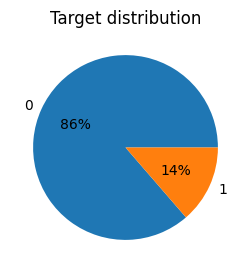

In [30]:
targets = processed_df['Stroke_Y/N']

temp = targets.value_counts()
temp

plt.figure(figsize=(6, 3))
plt.pie(temp, labels=temp.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

### Stratified Split
- First Split (80% train + 20% test)
- Second Split (80% train, 20% validation)


In [31]:
y = processed_df["Stroke_Y/N"]
X = processed_df.drop(columns=["Stroke_Y/N"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [32]:
y

,Stroke_Y/N
0,0
1,0
2,0
3,0
4,0
...,...
67962,0
67963,0
67964,0
67965,0


In [33]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Define models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    # "SVC": SVC(kernel='rbf', probability=True, random_state=42),

}

# Define number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    f1_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], []

    # Perform K-Fold Cross Validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # Compute metrics
        f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))
        precision_scores.append(precision_score(y_val, y_val_pred, average='weighted'))
        recall_scores.append(recall_score(y_val, y_val_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_val, y_val_pred))

    # Print average performance for this model
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")



Evaluating Decision Tree...
F1 Score: 0.9992 ± 0.0003
Precision: 0.9992 ± 0.0003
Recall: 0.9992 ± 0.0003
Accuracy: 0.9992 ± 0.0003

Evaluating Naïve Bayes...
F1 Score: 0.5846 ± 0.0223
Precision: 0.8813 ± 0.0014
Recall: 0.5226 ± 0.0216
Accuracy: 0.5226 ± 0.0216

Evaluating SVC...


KeyboardInterrupt: 

### SHAP and LIME Analysis

#### SHAP

In [ ]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [ ]:
X_test

##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [ ]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**


### Model Tracking With MLFlow

In [ ]:
!pip install -q mlflow pyngrok

In [ ]:
import mlflow
from pyngrok import ngrok

# Start MLflow tracking server
get_ipython().system_raw("mlflow server --host 0.0.0.0 --port 8081 --backend-store-uri sqlite:///mlflow.db &")

# Expose the MLflow tracking server
public_url = ngrok.connect(8081).public_url
print(f"MLflow Tracking UI: {public_url}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(public_url)

# Set Experiment
mlflow.set_experiment("Stroke Prediction Experiment")


In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")


    # log tags
    mlflow.set_tags({
        "model_type": "RandomForest",
        "framework": "sklearn",
        "experiment_name": "Model_Experiment",
        "random_state": "42"
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)